<a href="https://colab.research.google.com/github/nkanungo/EVA6/blob/main/DNN_Pytorch_Architecture_Changes_Best_working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We have taken Best Model from last assignment with Train accuracy: 98.73   validation accuracy: 99.43   Number of parameters: 7,836 and applied Group Normalization + L1, Layer Normalization + L2, Batch Normaliztion + L1 + L2

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from model import Net

Training
========
This is the basic training construct . The following changes has been done to the earlier network to accomodate 

1. L1 value as a parameter to the training function 

The Logic
=========
If the L1 value is  greater than zero 
  - Initialize the regularization loss to 0.0
  - Iterate through the model parameters
  - If the dimension is greater than 1 then 
  - The regularization error becomes the cumulative sum of all 
  - Again the regularization loss becomes the multiplication of all the L1 values 
  - The final loss becomes the cumulative sum of the regularization losses

In [3]:
from tqdm import tqdm


def train(model, device, train_loader, optimizer, epoch, train_loss_list, train_acc_list, l1_param=0.0):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  train_losses = []
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    
    if l1_param > 0.0:
        regularization_loss = 0.0

        for param in model.parameters():
            if param.dim() > 1 :
                regularization_loss += param.norm(1)

        regularization_loss *= l1_param
        loss += regularization_loss     
    
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
  train_acc_list.append(100*correct/processed)
  train_loss_list.append(sum(train_losses)/len(train_losses))

def test(model, device, test_loader, test_loss_list, test_acc_list):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_loss_list.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc_list.append(100. * correct / len(test_loader.dataset))

Misclassified Images
======================
In Any deep network the user must understand where things went wrong for improving the performance by retraining the model. The code below would help the developer to visually see where the network could not predict well. The misclassified images . An Important feedback to the network. 

In [4]:
def find_plot_misclassified_images(test_loader, model, num_display_images = 20):
    incorrect_image_list =[]
    predicted_label_list =[]
    correct_label_list = []
    for (i, [data, target]) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True).squeeze(1)         
        idxs_mask = (pred !=  target).view(-1)
        img_nm = data[idxs_mask].cpu().numpy()
        img_nm = img_nm.reshape(img_nm.shape[0], 28, 28)
        if img_nm.shape[0] > 0:
            img_list = [img_nm[i] for i in range(img_nm.shape[0])]
            incorrect_image_list.extend(img_list)
            predicted_label_list.extend(pred[idxs_mask].cpu().numpy())
            correct_label_list.extend(target[idxs_mask].cpu().numpy())

    plt.figure(figsize=(15,15))
    columns = 5
    i= 0
    # Display the list of 25 misclassified images
    for index, image in enumerate(incorrect_image_list) :
        ax = plt.subplot(5, 5, i+1)
        ax.set_title("Actual: " + str(correct_label_list[index]) + ", Predicted: " + str(predicted_label_list[index]))
        ax.axis('off')
        plt.imshow(image)
        i +=1
        if i== num_display_images:
            break

Steps
===
1. Define Hyper Parameters
2. Define Train and Test loaders


In [5]:
#torch.manual_seed(11)
batch_size = 64
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.RandomRotation((-7.0, 7.0), fill=(1,)),

                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Group Normalization + L1
The below code has been designed to include the Group Normalization with L1 regularization 
1. The group normalization should not add much parameters to the network, hence should not be computationally expensive than the vanilla 

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model_groupnorm_l1 = Net('GN').to(device)
summary(model_groupnorm_l1, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 28, 28]             108
              ReLU-2           [-1, 12, 28, 28]               0
         GroupNorm-3           [-1, 12, 28, 28]              24
         Dropout2d-4           [-1, 12, 28, 28]               0
            Conv2d-5           [-1, 12, 28, 28]           1,296
              ReLU-6           [-1, 12, 28, 28]               0
         GroupNorm-7           [-1, 12, 28, 28]              24
         Dropout2d-8           [-1, 12, 28, 28]               0
         MaxPool2d-9           [-1, 12, 14, 14]               0
           Conv2d-10           [-1, 14, 14, 14]           1,512
             ReLU-11           [-1, 14, 14, 14]               0
        GroupNorm-12           [-1, 14, 14, 14]              28
        Dropout2d-13           [-1, 14, 14, 14]               0
           Conv2d-14           [-1, 14,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [7]:
from torch.optim.lr_scheduler import StepLR

model_groupnorm_l1 =  Net('GN').to(device)
optimizer = optim.SGD(model_groupnorm_l1.parameters(), lr=0.19, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

EPOCHS = 25
train_loss_groupnorm_l1_list = []
train_acc_groupnorm_l1_list = []
test_loss_groupnorm_l1_list = []
test_acc_groupnorm_l1_list = []
for epoch in range(1, EPOCHS+1):
    print("EPOCH:", epoch)
    train(model_groupnorm_l1, device, train_loader, optimizer, epoch, train_loss_groupnorm_l1_list, train_acc_groupnorm_l1_list, l1_param= 0.0005 )
    test(model_groupnorm_l1, device, test_loader, test_loss_groupnorm_l1_list, test_acc_groupnorm_l1_list )
    scheduler.step()

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.6253539323806763 Batch_id=937 Accuracy=84.90: 100%|██████████| 938/938 [00:24<00:00, 37.57it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1323, Accuracy: 9580/10000 (95.80%)

EPOCH: 2


Loss=0.45118510723114014 Batch_id=937 Accuracy=92.27: 100%|██████████| 938/938 [00:24<00:00, 38.11it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1031, Accuracy: 9665/10000 (96.65%)

EPOCH: 3


Loss=0.5685924291610718 Batch_id=937 Accuracy=93.28: 100%|██████████| 938/938 [00:24<00:00, 38.35it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1042, Accuracy: 9654/10000 (96.54%)

EPOCH: 4


Loss=0.5353666543960571 Batch_id=937 Accuracy=93.36: 100%|██████████| 938/938 [00:24<00:00, 37.61it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0943, Accuracy: 9719/10000 (97.19%)

EPOCH: 5


Loss=0.7770866751670837 Batch_id=937 Accuracy=93.76: 100%|██████████| 938/938 [00:25<00:00, 37.41it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1044, Accuracy: 9663/10000 (96.63%)

EPOCH: 6


Loss=0.4103473424911499 Batch_id=937 Accuracy=93.70: 100%|██████████| 938/938 [00:24<00:00, 37.62it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1243, Accuracy: 9576/10000 (95.76%)

EPOCH: 7


Loss=0.48637035489082336 Batch_id=937 Accuracy=96.25: 100%|██████████| 938/938 [00:25<00:00, 37.41it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0570, Accuracy: 9826/10000 (98.26%)

EPOCH: 8


Loss=0.19444935023784637 Batch_id=937 Accuracy=96.48: 100%|██████████| 938/938 [00:24<00:00, 37.60it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0554, Accuracy: 9824/10000 (98.24%)

EPOCH: 9


Loss=0.16254250705242157 Batch_id=937 Accuracy=96.57: 100%|██████████| 938/938 [00:24<00:00, 37.89it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0500, Accuracy: 9829/10000 (98.29%)

EPOCH: 10


Loss=0.22378051280975342 Batch_id=937 Accuracy=96.33: 100%|██████████| 938/938 [00:24<00:00, 38.29it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0561, Accuracy: 9817/10000 (98.17%)

EPOCH: 11


Loss=0.19424372911453247 Batch_id=937 Accuracy=96.30: 100%|██████████| 938/938 [00:24<00:00, 38.15it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0571, Accuracy: 9815/10000 (98.15%)

EPOCH: 12


Loss=0.27100425958633423 Batch_id=937 Accuracy=96.24: 100%|██████████| 938/938 [00:24<00:00, 38.22it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0540, Accuracy: 9823/10000 (98.23%)

EPOCH: 13


Loss=0.12931548058986664 Batch_id=937 Accuracy=96.91: 100%|██████████| 938/938 [00:24<00:00, 38.39it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0464, Accuracy: 9847/10000 (98.47%)

EPOCH: 14


Loss=0.2326326221227646 Batch_id=937 Accuracy=97.16: 100%|██████████| 938/938 [00:24<00:00, 38.51it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0444, Accuracy: 9860/10000 (98.60%)

EPOCH: 15


Loss=0.15964877605438232 Batch_id=937 Accuracy=97.17: 100%|██████████| 938/938 [00:24<00:00, 38.28it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0459, Accuracy: 9857/10000 (98.57%)

EPOCH: 16


Loss=0.23798292875289917 Batch_id=937 Accuracy=97.19: 100%|██████████| 938/938 [00:24<00:00, 38.01it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0447, Accuracy: 9852/10000 (98.52%)

EPOCH: 17


Loss=0.23006220161914825 Batch_id=937 Accuracy=97.17: 100%|██████████| 938/938 [00:24<00:00, 38.29it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0427, Accuracy: 9862/10000 (98.62%)

EPOCH: 18


Loss=0.21810907125473022 Batch_id=937 Accuracy=97.25: 100%|██████████| 938/938 [00:24<00:00, 37.62it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0450, Accuracy: 9860/10000 (98.60%)

EPOCH: 19


Loss=0.19809314608573914 Batch_id=937 Accuracy=97.26: 100%|██████████| 938/938 [00:24<00:00, 38.08it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0432, Accuracy: 9864/10000 (98.64%)

EPOCH: 20


Loss=0.18637070059776306 Batch_id=937 Accuracy=97.32: 100%|██████████| 938/938 [00:24<00:00, 37.72it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0427, Accuracy: 9867/10000 (98.67%)

EPOCH: 21


Loss=0.24774578213691711 Batch_id=937 Accuracy=97.32: 100%|██████████| 938/938 [00:24<00:00, 37.94it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0423, Accuracy: 9866/10000 (98.66%)

EPOCH: 22


Loss=0.21964852511882782 Batch_id=937 Accuracy=97.25: 100%|██████████| 938/938 [00:25<00:00, 37.37it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0424, Accuracy: 9868/10000 (98.68%)

EPOCH: 23


Loss=0.11778990179300308 Batch_id=937 Accuracy=97.35: 100%|██████████| 938/938 [00:24<00:00, 37.71it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0420, Accuracy: 9873/10000 (98.73%)

EPOCH: 24


Loss=0.17270058393478394 Batch_id=937 Accuracy=97.28: 100%|██████████| 938/938 [00:25<00:00, 37.42it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0421, Accuracy: 9867/10000 (98.67%)

EPOCH: 25


Loss=0.17950546741485596 Batch_id=937 Accuracy=97.34: 100%|██████████| 938/938 [00:24<00:00, 37.63it/s]



Test set: Average loss: 0.0420, Accuracy: 9866/10000 (98.66%)



Observation
===========
The group normalization and L1 regularization didn't do a good job on model accuracy .
- The model validation accuracy droped down to 98.26%.
- However the validation accuracy is above train accuracy ( That's good news, which means this network has potential to improve further) 
- Let's observe the misclassified images and see where things went wrong 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


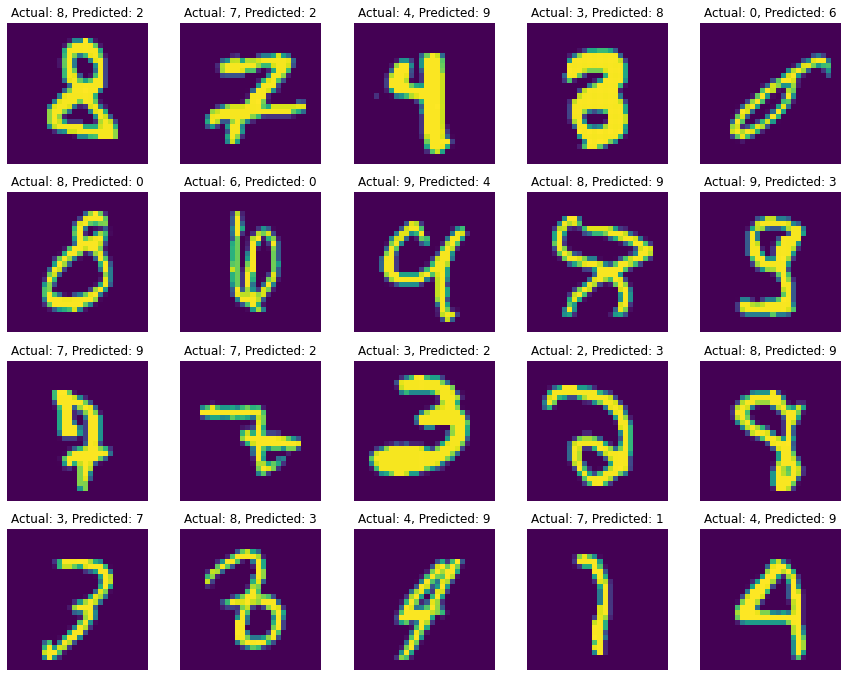

In [8]:
find_plot_misclassified_images(test_loader, model_groupnorm_l1)

## Layer Normalization + L2

The below code has been designed to include the Layer Normalization with L2 regularization 
 - The Layer normalization should add more parameters to the network, hence it should  be computationally expensive than the vanilla . Let's observe 

In [9]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model_layernorm_l2 = Net('LN').to(device)
summary(model_layernorm_l2, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 28, 28]             108
              ReLU-2           [-1, 12, 28, 28]               0
         LayerNorm-3           [-1, 12, 28, 28]          18,816
         Dropout2d-4           [-1, 12, 28, 28]               0
            Conv2d-5           [-1, 12, 28, 28]           1,296
              ReLU-6           [-1, 12, 28, 28]               0
         LayerNorm-7           [-1, 12, 28, 28]          18,816
         Dropout2d-8           [-1, 12, 28, 28]               0
         MaxPool2d-9           [-1, 12, 14, 14]               0
           Conv2d-10           [-1, 14, 14, 14]           1,512
             ReLU-11           [-1, 14, 14, 14]               0
        LayerNorm-12           [-1, 14, 14, 14]           5,488
        Dropout2d-13           [-1, 14, 14, 14]               0
           Conv2d-14           [-1, 14,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [23]:
model_layernorm_l2 =  Net('LN').to(device)
optimizer = optim.SGD(model_layernorm_l2.parameters(), lr=0.19, momentum=0.9,  weight_decay=0.001)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

EPOCHS = 25
train_loss_layernorm_l2_list = []
train_acc_layernorm_l2_list = []
test_loss_layernorm_l2_list = []
test_acc_layernorm_l2_list = []
for epoch in range(1, EPOCHS+1):
    print("EPOCH:", epoch)
    train(model_layernorm_l2, device, train_loader, optimizer, epoch, train_loss_layernorm_l2_list, train_acc_layernorm_l2_list )
    test(model_layernorm_l2, device, test_loader, test_loss_layernorm_l2_list, test_acc_layernorm_l2_list)
    scheduler.step()

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.2833016514778137 Batch_id=937 Accuracy=90.42: 100%|██████████| 938/938 [00:23<00:00, 39.64it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0995, Accuracy: 9705/10000 (97.05%)

EPOCH: 2


Loss=0.25044286251068115 Batch_id=937 Accuracy=94.55: 100%|██████████| 938/938 [00:23<00:00, 39.93it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1431, Accuracy: 9568/10000 (95.68%)

EPOCH: 3


Loss=0.09989463537931442 Batch_id=937 Accuracy=94.56: 100%|██████████| 938/938 [00:23<00:00, 40.10it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0952, Accuracy: 9725/10000 (97.25%)

EPOCH: 4


Loss=0.2111944556236267 Batch_id=937 Accuracy=94.67: 100%|██████████| 938/938 [00:23<00:00, 40.66it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1152, Accuracy: 9656/10000 (96.56%)

EPOCH: 5


Loss=0.07129672914743423 Batch_id=937 Accuracy=94.81: 100%|██████████| 938/938 [00:23<00:00, 40.34it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1144, Accuracy: 9649/10000 (96.49%)

EPOCH: 6


Loss=0.11177024990320206 Batch_id=937 Accuracy=94.76: 100%|██████████| 938/938 [00:23<00:00, 40.34it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0859, Accuracy: 9739/10000 (97.39%)

EPOCH: 7


Loss=0.06377828121185303 Batch_id=937 Accuracy=97.42: 100%|██████████| 938/938 [00:23<00:00, 40.66it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0421, Accuracy: 9878/10000 (98.78%)

EPOCH: 8


Loss=0.04422483593225479 Batch_id=937 Accuracy=97.84: 100%|██████████| 938/938 [00:23<00:00, 40.61it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0376, Accuracy: 9889/10000 (98.89%)

EPOCH: 9


Loss=0.09278760850429535 Batch_id=937 Accuracy=98.04: 100%|██████████| 938/938 [00:23<00:00, 40.73it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0433, Accuracy: 9869/10000 (98.69%)

EPOCH: 10


Loss=0.011937573552131653 Batch_id=937 Accuracy=97.99: 100%|██████████| 938/938 [00:23<00:00, 40.62it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0408, Accuracy: 9887/10000 (98.87%)

EPOCH: 11


Loss=0.027640078216791153 Batch_id=937 Accuracy=97.86: 100%|██████████| 938/938 [00:23<00:00, 40.18it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0406, Accuracy: 9881/10000 (98.81%)

EPOCH: 12


Loss=0.1406603306531906 Batch_id=937 Accuracy=97.82: 100%|██████████| 938/938 [00:23<00:00, 40.33it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0428, Accuracy: 9882/10000 (98.82%)

EPOCH: 13


Loss=0.032655514776706696 Batch_id=937 Accuracy=98.36: 100%|██████████| 938/938 [00:23<00:00, 40.13it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0324, Accuracy: 9906/10000 (99.06%)

EPOCH: 14


Loss=0.009379015304148197 Batch_id=937 Accuracy=98.62: 100%|██████████| 938/938 [00:23<00:00, 40.11it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 9910/10000 (99.10%)

EPOCH: 15


Loss=0.009426438249647617 Batch_id=937 Accuracy=98.69: 100%|██████████| 938/938 [00:23<00:00, 39.50it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9916/10000 (99.16%)

EPOCH: 16


Loss=0.017676401883363724 Batch_id=937 Accuracy=98.68: 100%|██████████| 938/938 [00:23<00:00, 40.01it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9918/10000 (99.18%)

EPOCH: 17


Loss=0.07864309847354889 Batch_id=937 Accuracy=98.78: 100%|██████████| 938/938 [00:23<00:00, 39.96it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 9918/10000 (99.18%)

EPOCH: 18


Loss=0.007824704051017761 Batch_id=937 Accuracy=98.75: 100%|██████████| 938/938 [00:23<00:00, 40.35it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9917/10000 (99.17%)

EPOCH: 19


Loss=0.004799077287316322 Batch_id=937 Accuracy=98.79: 100%|██████████| 938/938 [00:23<00:00, 40.55it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Accuracy: 9917/10000 (99.17%)

EPOCH: 20


Loss=0.016216393560171127 Batch_id=937 Accuracy=98.89: 100%|██████████| 938/938 [00:23<00:00, 40.35it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9923/10000 (99.23%)

EPOCH: 21


Loss=0.1558777093887329 Batch_id=937 Accuracy=98.89: 100%|██████████| 938/938 [00:23<00:00, 40.00it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Accuracy: 9922/10000 (99.22%)

EPOCH: 22


Loss=0.062218889594078064 Batch_id=937 Accuracy=98.86: 100%|██████████| 938/938 [00:23<00:00, 40.16it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9924/10000 (99.24%)

EPOCH: 23


Loss=0.009838546626269817 Batch_id=937 Accuracy=98.92: 100%|██████████| 938/938 [00:23<00:00, 40.12it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9924/10000 (99.24%)

EPOCH: 24


Loss=0.04003208130598068 Batch_id=937 Accuracy=98.95: 100%|██████████| 938/938 [00:23<00:00, 39.58it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9925/10000 (99.25%)

EPOCH: 25


Loss=0.011410150676965714 Batch_id=937 Accuracy=98.92: 100%|██████████| 938/938 [00:23<00:00, 40.34it/s]



Test set: Average loss: 0.0263, Accuracy: 9925/10000 (99.25%)



Observation
===========
The Layer normalization and L2 regularization improved the accuracy to 99.19%. So what can we infer from this 
- Did layer normalization improved the accuracy ?
- Or it was L2 regularization who was the differentiator
- Or the model worked better as it has more  number of parameters 

I think to understand this we need to take step by step approach . I think at this time we will keep out assumptions 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


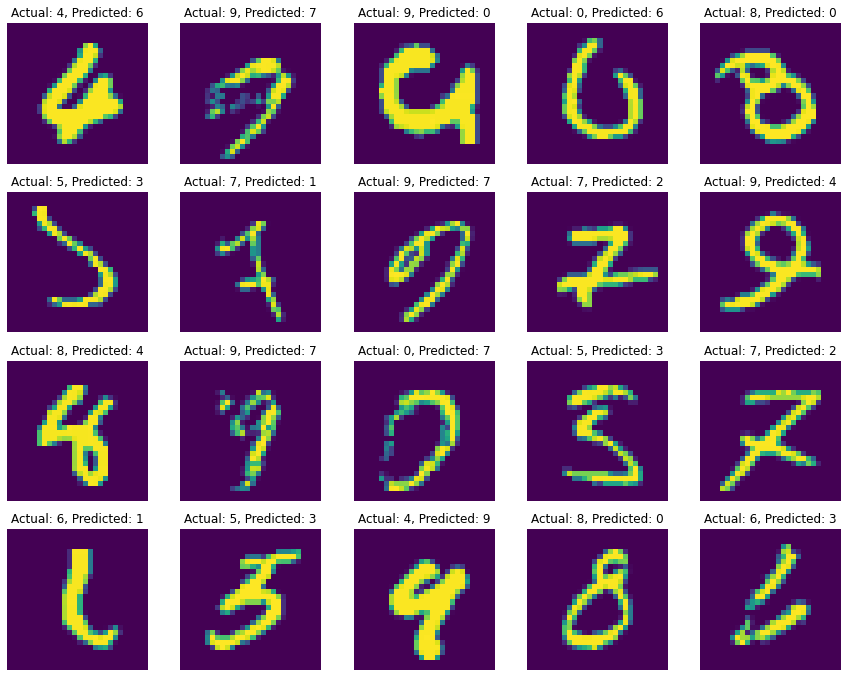

In [24]:
find_plot_misclassified_images(test_loader, model_layernorm_l2)

## Batch Normalization L1 + L2

The below code has been designed to include the our own Batch Normalization with both L1 & L2  regularization 


In [12]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model_batchnorm_l1_l2 = Net('BN').to(device)
summary(model_batchnorm_l1_l2, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 28, 28]             108
              ReLU-2           [-1, 12, 28, 28]               0
       BatchNorm2d-3           [-1, 12, 28, 28]              24
         Dropout2d-4           [-1, 12, 28, 28]               0
            Conv2d-5           [-1, 12, 28, 28]           1,296
              ReLU-6           [-1, 12, 28, 28]               0
       BatchNorm2d-7           [-1, 12, 28, 28]              24
         Dropout2d-8           [-1, 12, 28, 28]               0
         MaxPool2d-9           [-1, 12, 14, 14]               0
           Conv2d-10           [-1, 14, 14, 14]           1,512
             ReLU-11           [-1, 14, 14, 14]               0
      BatchNorm2d-12           [-1, 14, 14, 14]              28
        Dropout2d-13           [-1, 14, 14, 14]               0
           Conv2d-14           [-1, 14,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [13]:
model_layernorm_l2 =  Net('BN').to(device)
optimizer = optim.SGD(model_layernorm_l2.parameters(), lr=0.19, momentum=0.9,  weight_decay=0.001)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

EPOCHS = 25
train_loss_batchnorm_l1_l2_list = []
train_acc_batchnorm_l1_l2_list = []
test_loss_batchnorm_l1_l2_list = []
test_acc_batchnorm_l1_l2_list = []
for epoch in range(1, EPOCHS+1):
    print("EPOCH:", epoch)
    train(model_layernorm_l2, device, train_loader, optimizer, epoch, train_loss_batchnorm_l1_l2_list, train_acc_batchnorm_l1_l2_list, l1_param= 0.0005 )
    test(model_layernorm_l2, device, test_loader, test_loss_batchnorm_l1_l2_list, test_acc_batchnorm_l1_l2_list)
    scheduler.step()

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.6775599718093872 Batch_id=937 Accuracy=91.08: 100%|██████████| 938/938 [00:24<00:00, 38.29it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1572, Accuracy: 9486/10000 (94.86%)

EPOCH: 2


Loss=1.008144736289978 Batch_id=937 Accuracy=93.08: 100%|██████████| 938/938 [00:24<00:00, 37.79it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1252, Accuracy: 9630/10000 (96.30%)

EPOCH: 3


Loss=0.4390850067138672 Batch_id=937 Accuracy=93.24: 100%|██████████| 938/938 [00:24<00:00, 37.68it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1629, Accuracy: 9465/10000 (94.65%)

EPOCH: 4


Loss=0.40635353326797485 Batch_id=937 Accuracy=93.32: 100%|██████████| 938/938 [00:24<00:00, 37.80it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0959, Accuracy: 9705/10000 (97.05%)

EPOCH: 5


Loss=0.5987620949745178 Batch_id=937 Accuracy=93.31: 100%|██████████| 938/938 [00:24<00:00, 37.83it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1702, Accuracy: 9471/10000 (94.71%)

EPOCH: 6


Loss=0.5115355849266052 Batch_id=937 Accuracy=93.23: 100%|██████████| 938/938 [00:24<00:00, 37.68it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1263, Accuracy: 9612/10000 (96.12%)

EPOCH: 7


Loss=0.21725790202617645 Batch_id=937 Accuracy=97.00: 100%|██████████| 938/938 [00:24<00:00, 38.27it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0489, Accuracy: 9841/10000 (98.41%)

EPOCH: 8


Loss=0.3083438277244568 Batch_id=937 Accuracy=96.95: 100%|██████████| 938/938 [00:24<00:00, 38.34it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0497, Accuracy: 9852/10000 (98.52%)

EPOCH: 9


Loss=0.20322367548942566 Batch_id=937 Accuracy=96.86: 100%|██████████| 938/938 [00:24<00:00, 38.04it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0518, Accuracy: 9831/10000 (98.31%)

EPOCH: 10


Loss=0.20028862357139587 Batch_id=937 Accuracy=96.78: 100%|██████████| 938/938 [00:25<00:00, 37.38it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0598, Accuracy: 9817/10000 (98.17%)

EPOCH: 11


Loss=0.20677359402179718 Batch_id=937 Accuracy=96.73: 100%|██████████| 938/938 [00:25<00:00, 37.30it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0462, Accuracy: 9854/10000 (98.54%)

EPOCH: 12


Loss=0.17156198620796204 Batch_id=937 Accuracy=96.73: 100%|██████████| 938/938 [00:24<00:00, 37.75it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0513, Accuracy: 9842/10000 (98.42%)

EPOCH: 13


Loss=0.2411540448665619 Batch_id=937 Accuracy=97.75: 100%|██████████| 938/938 [00:24<00:00, 38.45it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0347, Accuracy: 9891/10000 (98.91%)

EPOCH: 14


Loss=0.13335759937763214 Batch_id=937 Accuracy=97.99: 100%|██████████| 938/938 [00:24<00:00, 38.03it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0334, Accuracy: 9898/10000 (98.98%)

EPOCH: 15


Loss=0.16553469002246857 Batch_id=937 Accuracy=98.02: 100%|██████████| 938/938 [00:24<00:00, 37.78it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0331, Accuracy: 9901/10000 (99.01%)

EPOCH: 16


Loss=0.17287011444568634 Batch_id=937 Accuracy=97.99: 100%|██████████| 938/938 [00:24<00:00, 37.61it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0333, Accuracy: 9900/10000 (99.00%)

EPOCH: 17


Loss=0.1521340310573578 Batch_id=937 Accuracy=98.00: 100%|██████████| 938/938 [00:24<00:00, 37.54it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0361, Accuracy: 9889/10000 (98.89%)

EPOCH: 18


Loss=0.13013333082199097 Batch_id=937 Accuracy=98.02: 100%|██████████| 938/938 [00:25<00:00, 37.34it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0363, Accuracy: 9891/10000 (98.91%)

EPOCH: 19


Loss=0.18604853749275208 Batch_id=937 Accuracy=98.23: 100%|██████████| 938/938 [00:25<00:00, 37.44it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0309, Accuracy: 9907/10000 (99.07%)

EPOCH: 20


Loss=0.12212802469730377 Batch_id=937 Accuracy=98.32: 100%|██████████| 938/938 [00:25<00:00, 37.29it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0311, Accuracy: 9904/10000 (99.04%)

EPOCH: 21


Loss=0.24473528563976288 Batch_id=937 Accuracy=98.37: 100%|██████████| 938/938 [00:25<00:00, 37.51it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Accuracy: 9916/10000 (99.16%)

EPOCH: 22


Loss=0.15160247683525085 Batch_id=937 Accuracy=98.31: 100%|██████████| 938/938 [00:25<00:00, 37.42it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Accuracy: 9916/10000 (99.16%)

EPOCH: 23


Loss=0.12902167439460754 Batch_id=937 Accuracy=98.31: 100%|██████████| 938/938 [00:24<00:00, 38.02it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0299, Accuracy: 9911/10000 (99.11%)

EPOCH: 24


Loss=0.13071933388710022 Batch_id=937 Accuracy=98.35: 100%|██████████| 938/938 [00:24<00:00, 38.21it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9915/10000 (99.15%)

EPOCH: 25


Loss=0.2011633962392807 Batch_id=937 Accuracy=98.38: 100%|██████████| 938/938 [00:24<00:00, 38.03it/s]



Test set: Average loss: 0.0293, Accuracy: 9913/10000 (99.13%)



Observation
===========
The Batch normalization and L1/L2 regularization improved the accuracy to 99.11% with same number of parameters 

- So possibly having both L1/L2 regularization improved the accuracy
- Or the Batch normalization improved it 

Let's see the images and observe the differences if we can 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


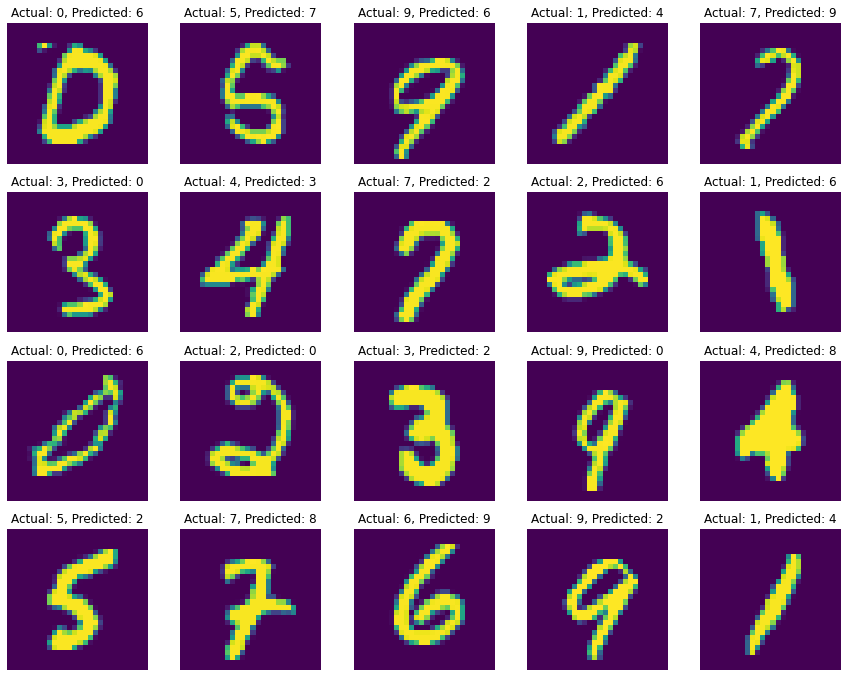

In [14]:
find_plot_misclassified_images(test_loader, model_batchnorm_l1_l2)

## Tain/Test Loss and Accuracy Plots for all the three models

In [25]:
import matplotlib.pyplot as plt
def plot_train_loss(train_loss_groupnorm_l1_list, train_loss_layernorm_l2_list, train_loss_batchnorm_l1_l2_list):
    fig, axs = plt.subplots(figsize=(5,5))
    axs.plot(train_loss_groupnorm_l1_list, label="Group Normalization + L1 Train Loss")
    axs.plot(train_loss_layernorm_l2_list, label="Layer Normalization + L2 Train Loss")
    axs.plot(train_loss_batchnorm_l1_l2_list, label="Batch Normalization + L1 + L2 Train Loss")
    axs.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

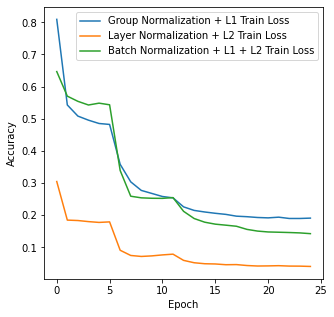

In [26]:
plot_train_loss(train_loss_groupnorm_l1_list, train_loss_layernorm_l2_list, train_loss_batchnorm_l1_l2_list)

Observation
===========
 From the training curve we see
 - Group Normalization + L1 the loss started high and remained high after 20 epochs 
 - Layer Normalization + L2 the loss started lower than the above and remained lower as well  after 20 epochs 
 - Finally the Batch Normalization + L1 + L2  the loss started lowest and ended lowest as well

 While it's seen that the BN/L1/L2 did well in training here , but which factor contributed is still unclear which needs a detail study 

In [27]:
def plot_test_loss(test_loss_groupnorm_l1_list, test_loss_layernorm_l2_list, test_loss_batchnorm_l1_l2_list):
    fig, axs = plt.subplots(figsize=(5,5))
    axs.plot(test_loss_groupnorm_l1_list, label="Group Normalization + L1 Test Loss")
    axs.plot(test_loss_layernorm_l2_list, label="Layer Normalization + L2 Test Loss")
    axs.plot(test_loss_batchnorm_l1_l2_list, label="Batch Normalization + L1 + L2 Test Loss")
    axs.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

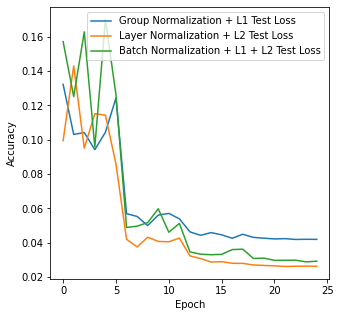

In [28]:
plot_test_loss(test_loss_groupnorm_l1_list, test_loss_layernorm_l2_list, test_loss_batchnorm_l1_l2_list)

Test Loss Observation
====================
 From the training curve we could see a clear difference , however after observing the test loss we can say 
 - The Batch norm + L1+ L2 started with a higher loss but did well to reduce it almost to the lowest 

 - While the Group Normalization + L1 started lower it ended on a higher side ( We may infer here that this didn't do well w.r.t the evaluation . But this is completely based on this study 
 - Layer Normalization + L2 remained fairly similar 

In [29]:
def plot_train_accuracy(train_acc_groupnorm_l1_list, train_acc_layernorm_l2_list, train_acc_batchnorm_l1_l2_list):
    fig, axs = plt.subplots(figsize=(5,5))
    axs.plot(train_acc_groupnorm_l1_list, label="Group Normalization + L1 Train Accuracy")
    axs.plot(train_acc_layernorm_l2_list, label="Layer Normalization + L2 Train Accuracy")
    axs.plot(train_acc_batchnorm_l1_l2_list, label="Batch Normalization + L1 + L2 Train Accuracy")
    axs.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

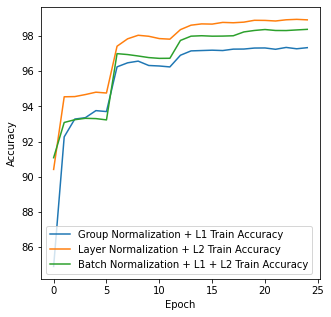

In [30]:
plot_train_accuracy(train_acc_groupnorm_l1_list, train_acc_layernorm_l2_list, train_acc_batchnorm_l1_l2_list)

Train Accuracy Observation
===========
 From the training curve we see
 
 - Layer Normalization + L2 the loss attained a better accuracy than the others while Group Normalization + L1 was the lowest 
 - However as discussed before the reason could be the increase in number of parameters
 - Here with this study we will not infer anything rather wait for the next phase of study

In [31]:
def plot_test_accuracy(test_acc_groupnorm_l1_list, test_acc_layernorm_l2_list, test_acc_batchnorm_l1_l2_list):
    fig, axs = plt.subplots(figsize=(5,5))
    axs.plot(test_acc_groupnorm_l1_list, label="Group Normalization + L1 Test Accuracy")
    axs.plot(test_acc_layernorm_l2_list, label="Layer Normalization + L2 Test Accuracy")
    axs.plot(test_acc_batchnorm_l1_l2_list, label="Batch Normalization + L1 + L2 Test Accuracy")
    axs.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

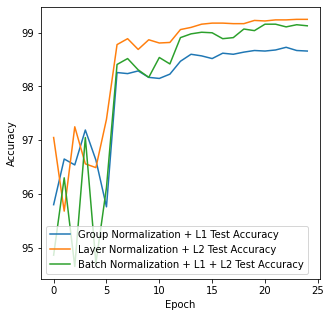

In [32]:
plot_test_accuracy(test_acc_groupnorm_l1_list, test_acc_layernorm_l2_list, test_acc_batchnorm_l1_l2_list)

Test Accuracy Observation
===========
 From the training curve we see
 
 - Layer Normalization + L2 the loss attained a better accuracy than the others while Group Normalization + L1 was the lowest 
 - However as discussed before the reason could be the increase in number of parameters
 - Here with this study we will not infer anything rather wait for the next phase of study